We will train regression models (Linear Regression and Decision Tree) on the preprocessed dataset and evaluate their performance on training, validation, and test sets.

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance
import seaborn as sns
import mlflow.sklearn

import warnings
import os
warnings.filterwarnings('ignore')

In [78]:
mlflow_tracking_uri = os.path.join(os.path.dirname(os.getcwd()), 'mlruns')
print(f"MLflow tracking URI: {mlflow_tracking_uri}")

# Change to \\ if on Windows
if os.name == 'nt':
    mlflow.set_tracking_uri(f"file:\\{mlflow_tracking_uri}")
else:
    mlflow.set_tracking_uri(f"file://{mlflow_tracking_uri}")

mlflow.end_run()
mlflow.set_experiment("regression_models")

MLflow tracking URI: /Users/hayden/UPEI/CS4120_ML/CS4120-MLProject/project/mlruns


<Experiment: artifact_location='file:///Users/hayden/UPEI/CS4120_ML/CS4120-MLProject/project/mlruns/945938244459471495', creation_time=1763763374004, experiment_id='945938244459471495', last_update_time=1763763374004, lifecycle_stage='active', name='regression_models', tags={}>

In [79]:
# Step 1: Load the data
train_data = pd.read_csv('../data/train.csv')

In [80]:
# Step 2: Data Preprocessing

# Separate features and target
X = train_data.drop(['Id', 'SalePrice'], axis=1)
y = np.log1p(train_data['SalePrice'])

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [81]:
# Step 2.1: Remove low variance columns (variance threshold = 0.01 for numeric features)
from sklearn.feature_selection import VarianceThreshold

# For numeric features only
numeric_data = X[numeric_features]
var_threshold = VarianceThreshold(threshold=0.01)
var_threshold.fit(numeric_data)
low_var_cols = [col for col, var in zip(numeric_features, var_threshold.variances_) if var < 0.01]

# Remove low variance columns
X = X.drop(columns=low_var_cols)
numeric_features = [col for col in numeric_features if col not in low_var_cols]

In [82]:
# Step 2.2: Fill missing values
missing_counts = X.isnull().sum()
print(missing_counts[missing_counts > 0])

# Fill numeric columns with mean
for col in numeric_features:
    if X[col].isnull().any():
        X.loc[:, col] = X[col].fillna(X[col].mean())

# Fill categorical columns with mode
for col in categorical_features:
    if X[col].isnull().any():
        X.loc[:, col] = X[col].fillna(X[col].mode()[0])

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [83]:
# Step 2.3: Encode categorical variables
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

In [84]:
# Step 2.4: Feature Engineering
initial_features = X.shape[1]

# Combine bathroom features
X['TotalBath'] = X['FullBath'] + 0.5 * X['HalfBath'] + X['BsmtFullBath'] + 0.5 * X['BsmtHalfBath']
X = X.drop(['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], axis=1)

# Combine porch features into one
X['TotalPorchSF'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['3SsnPorch'] + X['ScreenPorch']
X = X.drop(['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], axis=1)

# Drop low-variance features that add noise
low_var_features = ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']
features_to_drop = [f for f in low_var_features if f in X.columns]
if features_to_drop:
    X = X.drop(features_to_drop, axis=1)

# Drop Year/Month sold (temporal features may cause overfitting)
temporal_features = ['MoSold', 'YrSold']
temporal_to_drop = [f for f in temporal_features if f in X.columns]
if temporal_to_drop:
    X = X.drop(temporal_to_drop, axis=1)

# Combine quality features
X['OverallScore'] = X['OverallQual'] * X['OverallCond']

final_features = X.shape[1]

In [85]:
# Step 3: Feature Selection using Decision Tree
# Create a simple Decision Tree for feature selection
feature_selector = DecisionTreeRegressor(max_depth=10, random_state=42)
feature_selector.fit(X, y)

feature_importance_before = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_selector.feature_importances_
}).sort_values('importance', ascending=False)


# Use SelectFromModel with stricter threshold to select fewer features
selector = SelectFromModel(feature_selector, threshold='0.2*median', prefit=True, max_features=60)
X_selected = selector.transform(X)

selected_features_mask = selector.get_support()
selected_features = X.columns[selected_features_mask].tolist()

print(f"\nSelected features ({len(selected_features)}):")
for i, feat in enumerate(selected_features, 1):
    importance = feature_importance_before[feature_importance_before['feature'] == feat]['importance'].values[0]
    print(f"  {i:2d}. {feat:25s} (importance: {importance:.4f})")

# Update X to use only selected features
X = pd.DataFrame(X_selected, columns=selected_features, index=X.index)


Selected features (46):
   1. MSSubClass                (importance: 0.0005)
   2. MSZoning                  (importance: 0.0053)
   3. LotFrontage               (importance: 0.0079)
   4. LotArea                   (importance: 0.0097)
   5. LandContour               (importance: 0.0003)
   6. LotConfig                 (importance: 0.0004)
   7. LandSlope                 (importance: 0.0005)
   8. Neighborhood              (importance: 0.0059)
   9. Condition1                (importance: 0.0008)
  10. HouseStyle                (importance: 0.0028)
  11. OverallQual               (importance: 0.5736)
  12. OverallCond               (importance: 0.0039)
  13. YearBuilt                 (importance: 0.0128)
  14. YearRemodAdd              (importance: 0.0065)
  15. Exterior2nd               (importance: 0.0015)
  16. MasVnrType                (importance: 0.0014)
  17. MasVnrArea                (importance: 0.0020)
  18. ExterCond                 (importance: 0.0016)
  19. Foundation     

In [86]:
# Step 4: Train-Test Split (80-20, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nRemoving outliers from Training set only...")
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = (y_train >= lower_bound) & (y_train <= upper_bound)

# Apply mask to Training data
X_train = X_train[outlier_mask]
y_train = y_train[outlier_mask]

print(f"Removed {(~outlier_mask).sum()} outliers from Training data")
print(f"Final Training set size: {X_train.shape}")
print(f"Final Test set size: {X_test.shape}")


Removing outliers from Training set only...
Removed 20 outliers from Training data
Final Training set size: (1148, 46)
Final Test set size: (292, 46)


In [87]:
# Step 5: Hyperparameter tuning with 4-fold cross-validation for Ridge Regression
print("\nHyperparameter tuning using GridSearchCV with 4-fold CV...")

alpha_values = [1, 10, 15, 20, 25, 50, 75, 100]
param_grid_lr = {'alpha': alpha_values,
                 'max_iter': [1000, 5000, 10000],
                 'tol': [1e-4, 1e-3, 1e-2]}

print("\nHyperparameters to tune:")
for param, values in param_grid_lr.items():
    print(f"  {param}: {values}")

# Initialize Decision Tree Regressor
ridge = Ridge(random_state=42)

# Grid Search with 4-fold CV
grid_search_lr = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid_lr,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("\nTraining with cross-validation (this may take a while)...")
grid_search_lr.fit(X_train, y_train)
best_cv_lr_log = np.sqrt(-grid_search_lr.best_score_)
mean_log_y = np.mean(y_train)
best_cv_lr = np.exp(mean_log_y) * best_cv_lr_log

print("\n" + "="*50)
print("Best hyperparameters found:")
print("="*50)
for param, value in grid_search_lr.best_params_.items():
    print(f"  {param}: {value}")
best_cv_lr = np.sqrt(-grid_search_lr.best_score_)
print(f"\nBest CV RMSE: ${np.sqrt(-grid_search_lr.best_score_):,.2f}")


Hyperparameter tuning using GridSearchCV with 4-fold CV...

Hyperparameters to tune:
  alpha: [1, 10, 15, 20, 25, 50, 75, 100]
  max_iter: [1000, 5000, 10000]
  tol: [0.0001, 0.001, 0.01]

Training with cross-validation (this may take a while)...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_



Best hyperparameters found:
  alpha: 10
  max_iter: 1000
  tol: 0.0001

Best CV RMSE: $0.15


/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:2

In [88]:
# Step 5: Hyperparameter tuning with 5-fold cross-validation for Decision Tree Regressor
print("\nHyperparameter tuning using GridSearchCV with 4-fold CV...")

param_grid_dt = {
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [50, 100, 200, 300],
    'min_samples_leaf': [30, 50, 70, 100],
    'max_features': ['sqrt', 'log2', 0.3],
    'ccp_alpha': [0.0, 5.0, 10.0, 20.0, 50.0],
    'criterion': ['squared_error', 'friedman_mse']
}


print("\nHyperparameters to tune:")
for param, values in param_grid_dt.items():
    print(f"  {param}: {values}")

# Initialize Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Grid Search with 4-fold CV
grid_search_dt = GridSearchCV(
    estimator=dt_regressor,
    param_grid=param_grid_dt,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("\nTraining with cross-validation (this may take a while)...")
grid_search_dt.fit(X_train, y_train)
best_cv_dt_log = np.sqrt(-grid_search_dt.best_score_)
best_cv_dt = np.exp(mean_log_y) * best_cv_dt_log

print("\n" + "="*50)
print("Best hyperparameters found:")
print("="*50)
for param, value in grid_search_dt.best_params_.items():
    print(f"  {param}: {value}")
best_cv_dt = np.sqrt(-grid_search_dt.best_score_)
print(f"\nBest CV RMSE: ${np.sqrt(-grid_search_dt.best_score_):,.2f}")


Hyperparameter tuning using GridSearchCV with 4-fold CV...

Hyperparameters to tune:
  max_depth: [2, 3, 4, 5]
  min_samples_split: [50, 100, 200, 300]
  min_samples_leaf: [30, 50, 70, 100]
  max_features: ['sqrt', 'log2', 0.3]
  ccp_alpha: [0.0, 5.0, 10.0, 20.0, 50.0]
  criterion: ['squared_error', 'friedman_mse']

Training with cross-validation (this may take a while)...
Fitting 5 folds for each of 1920 candidates, totalling 9600 fits

Best hyperparameters found:
  ccp_alpha: 0.0
  criterion: squared_error
  max_depth: 5
  max_features: log2
  min_samples_leaf: 30
  min_samples_split: 50

Best CV RMSE: $0.19


In [89]:
# Step 6: Ridge Regression, Train final model with best parameters
print("\nTraining final model with best parameters...")
best_model_lr = grid_search_lr.best_estimator_

y_train_pred_log_lr = best_model_lr.predict(X_train)
y_train_pred_lr = np.expm1(y_train_pred_log_lr)
y_train_actual = np.expm1(y_train)

train_rmse_lr = np.sqrt(mean_squared_error(y_train_actual, y_train_pred_lr))
train_mae_lr = mean_absolute_error(y_train_actual, y_train_pred_lr)
train_r2_lr = r2_score(y_train_actual, y_train_pred_lr)

print(f"\nTraining Performance:")
print(f"  RMSE: ${train_rmse_lr:,.2f}")
print(f"  MAE: ${train_mae_lr:,.2f}")
print(f"  R² Score: {train_r2_lr:.4f}")


Training final model with best parameters...

Training Performance:
  RMSE: $32,148.43
  MAE: $16,619.20
  R² Score: 0.7832


In [90]:
# Step 6: Decision Tree Regressor, Train final model with best parameters
best_model_dt = grid_search_dt.best_estimator_

y_train_pred_log_dt = best_model_dt.predict(X_train)
y_train_pred_dt = np.expm1(y_train_pred_log_dt)
y_train_actual = np.expm1(y_train)

train_rmse_dt = np.sqrt(mean_squared_error(y_train_actual, y_train_pred_dt))
train_mae_dt = mean_absolute_error(y_train_actual, y_train_pred_dt)
train_r2_dt = r2_score(y_train_actual, y_train_pred_dt)

print(f"\nTraining Performance:")
print(f"  RMSE: ${train_rmse_dt:,.2f}")
print(f"  MAE: ${train_mae_dt:,.2f}")
print(f"  R² Score: {train_r2_dt:.4f}")


Training Performance:
  RMSE: $31,930.55
  MAE: $22,878.43
  R² Score: 0.7861


In [91]:
# Step 7: Ridge Regression, Test on test set and report
print("\nEvaluating on test set...")
y_test_pred_log = best_model_lr.predict(X_test)
y_test_pred = np.expm1(y_test_pred_log)
y_test_actual = np.expm1(y_test)
test_rmse_lr = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
test_mae_lr = mean_absolute_error(y_test_actual, y_test_pred)
test_r2_lr = r2_score(y_test_actual, y_test_pred)

print("\n" + "="*50)
print("TEST SET PERFORMANCE")
print("="*50)
print(f"  RMSE: ${test_rmse_lr:,.2f}")
print(f"  R² Score: {test_r2_lr:.4f}")
print(f"  Mean Absolute Error: ${test_mae_lr:,.2f}")


Evaluating on test set...

TEST SET PERFORMANCE
  RMSE: $29,738.53
  R² Score: 0.8847
  Mean Absolute Error: $18,705.98


In [92]:
# Step 7: Decision Tree Regressor, Test on test set and report
print("\nEvaluating on test set...")
y_test_pred_dt_log = best_model_dt.predict(X_test)
y_test_pred_dt = np.expm1(y_test_pred_dt_log)
y_test_actual = np.expm1(y_test)

test_rmse_dt = np.sqrt(mean_squared_error(y_test_actual, y_test_pred_dt))
test_mae_dt = mean_absolute_error(y_test_actual, y_test_pred_dt)
test_r2_dt = r2_score(y_test_actual, y_test_pred_dt)

print("\n" + "="*50)
print("TEST SET PERFORMANCE")
print("="*50)
print(f"  RMSE: ${test_rmse_dt:,.2f}")
print(f"  R² Score: {test_r2_dt:.4f}")
print(f"  Mean Absolute Error: ${test_mae_dt:,.2f}")
print(f"  Median Absolute Error: ${np.median(np.abs(y_test_actual - y_test_pred_dt)):,.2f}")


Evaluating on test set...

TEST SET PERFORMANCE
  RMSE: $45,750.17
  R² Score: 0.7271
  Mean Absolute Error: $27,183.25
  Median Absolute Error: $18,428.09



Generating learning curve...


/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


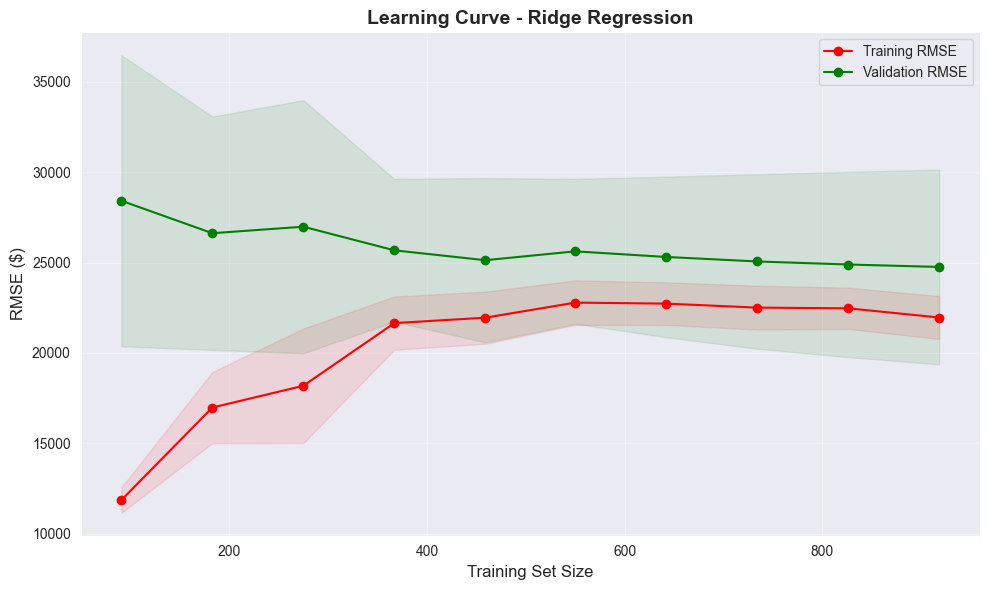


Learning curve generated successfully!


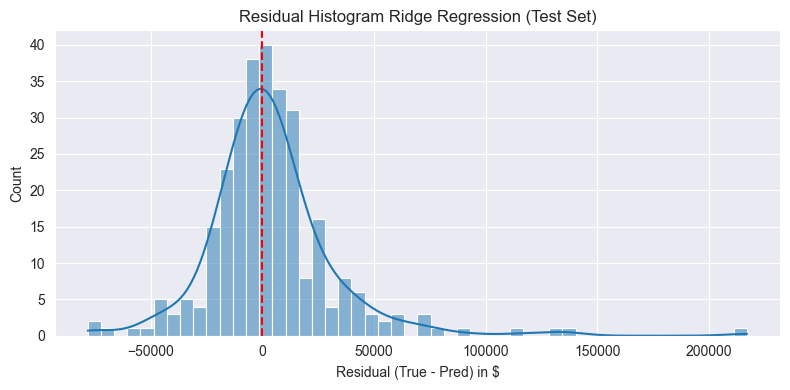

/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: Runti

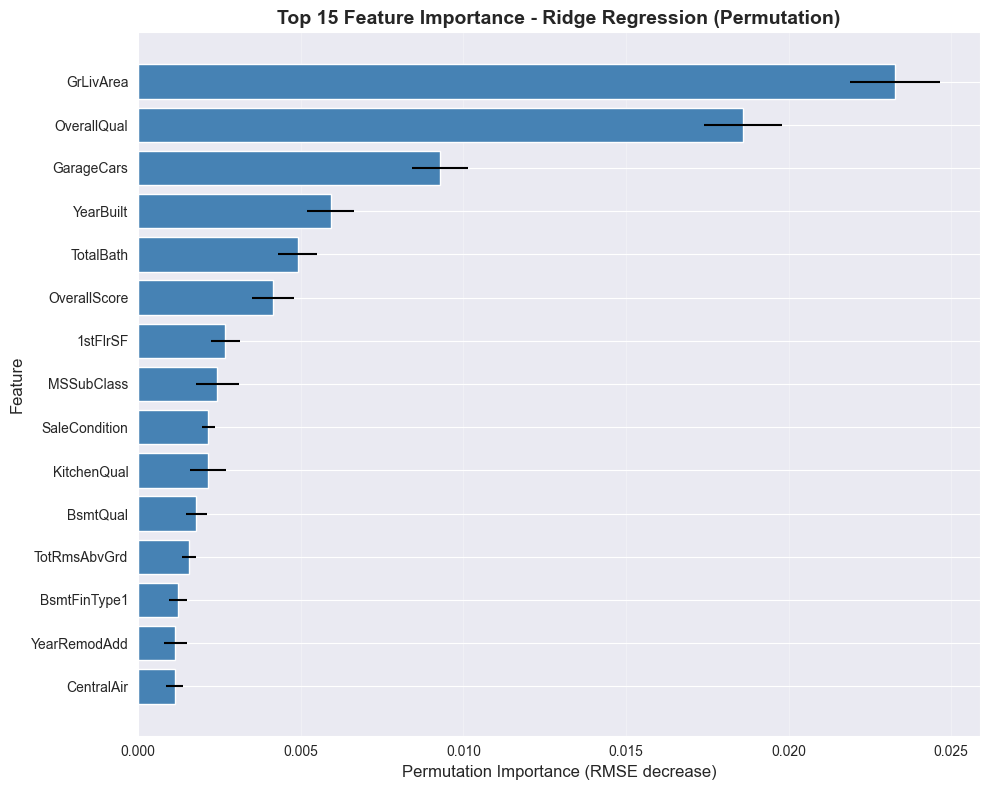


Top 15 most important features by permutation importance:
   1. GrLivArea                 importance: 0.0233 (±0.0014)
   2. OverallQual               importance: 0.0186 (±0.0012)
   3. GarageCars                importance: 0.0093 (±0.0009)
   4. YearBuilt                 importance: 0.0059 (±0.0007)
   5. TotalBath                 importance: 0.0049 (±0.0006)
   6. OverallScore              importance: 0.0042 (±0.0007)
   7. 1stFlrSF                  importance: 0.0027 (±0.0004)
   8. MSSubClass                importance: 0.0024 (±0.0007)
   9. SaleCondition             importance: 0.0022 (±0.0002)
  10. KitchenQual               importance: 0.0021 (±0.0006)
  11. BsmtQual                  importance: 0.0018 (±0.0003)
  12. TotRmsAbvGrd              importance: 0.0016 (±0.0002)
  13. BsmtFinType1              importance: 0.0012 (±0.0003)
  14. YearRemodAdd              importance: 0.0011 (±0.0004)
  15. CentralAir                importance: 0.0011 (±0.0003)


In [93]:
# Step 8: Ridge Regression Learning Curve with RMSE
with mlflow.start_run(run_name="Ridge_Regression"):
    mlflow.log_param("model_type", "Ridge")
    mlflow.log_param("cv_folds", 4)
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)
    mlflow.log_params({f"best_{k}": v for k, v in grid_search_lr.best_params_.items()})
    mlflow.log_metric("cv_rmse", best_cv_lr)
    mlflow.log_metric("train_rmse", train_rmse_lr)
    mlflow.log_metric("train_mae", train_mae_lr)


print("\nGenerating learning curve...")

# Calculate learning curve
train_sizes, train_scores, val_scores = learning_curve(
    best_model_lr,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    random_state=42
)

train_rmse_scores = np.sqrt(-train_scores)
val_rmse_scores = np.sqrt(-val_scores)
mean_log_y = np.mean(y_train)
train_rmse_dollars = np.exp(mean_log_y) * train_rmse_scores
val_rmse_dollars = np.exp(mean_log_y) * val_rmse_scores

train_rmse_mean = np.mean(train_rmse_dollars, axis=1)
train_rmse_std = np.std(train_rmse_dollars, axis=1)
val_rmse_mean = np.mean(val_rmse_dollars, axis=1)
val_rmse_std = np.std(val_rmse_dollars, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmse_mean, 'o-', color='r', label='Training RMSE')
plt.fill_between(train_sizes,
                 train_rmse_mean - train_rmse_std,
                 train_rmse_mean + train_rmse_std,
                 alpha=0.1, color='r')

plt.plot(train_sizes, val_rmse_mean, 'o-', color='g', label='Validation RMSE')
plt.fill_between(train_sizes,
                 val_rmse_mean - val_rmse_std,
                 val_rmse_mean + val_rmse_std,
                 alpha=0.1, color='g')

plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('RMSE ($)', fontsize=12)
plt.title('Learning Curve - Ridge Regression', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
mlflow.log_figure(plt.gcf(), 'lr_learning_curve.png')
plt.show()

print("\nLearning curve generated successfully!")

#Linear Regression Visualizations

# Residual histogram
y_test_actual = np.expm1(y_test)
y_test_pred_actual = np.expm1(y_test_pred_log)
residuals = y_test_actual - y_test_pred_actual

plt.figure(figsize=(8,4))
sns.histplot(residuals, bins=50, kde=True, color='C0')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residual (True - Pred) in $')
plt.title('Residual Histogram Ridge Regression (Test Set)')
plt.tight_layout()
mlflow.log_figure(plt.gcf(), 'lr_residual_histogram.png')
plt.show()

# Permutation importance
perm_importance = permutation_importance(
    best_model_lr,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Get feature importance
perm_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('importance', ascending=False)

# Plot top 15 features
top_n = 15
plt.figure(figsize=(10, 8))
top_features = perm_importance_df.head(top_n)
plt.barh(range(top_n), top_features['importance'].values, xerr=top_features['std'].values, color='steelblue')
plt.yticks(range(top_n), top_features['feature'].values)
plt.xlabel('Permutation Importance (RMSE decrease)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Top {top_n} Feature Importance - Ridge Regression (Permutation)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
mlflow.log_figure(plt.gcf(), 'lr_permutation_importance.png')
plt.show()

print(f"\nTop {top_n} most important features by permutation importance:")
for i, row in enumerate(top_features.itertuples(), 1):
    print(f"  {i:2d}. {row.feature:25s} importance: {row.importance:.4f} (±{row.std:.4f})")

mlflow.end_run()



Generating learning curve...


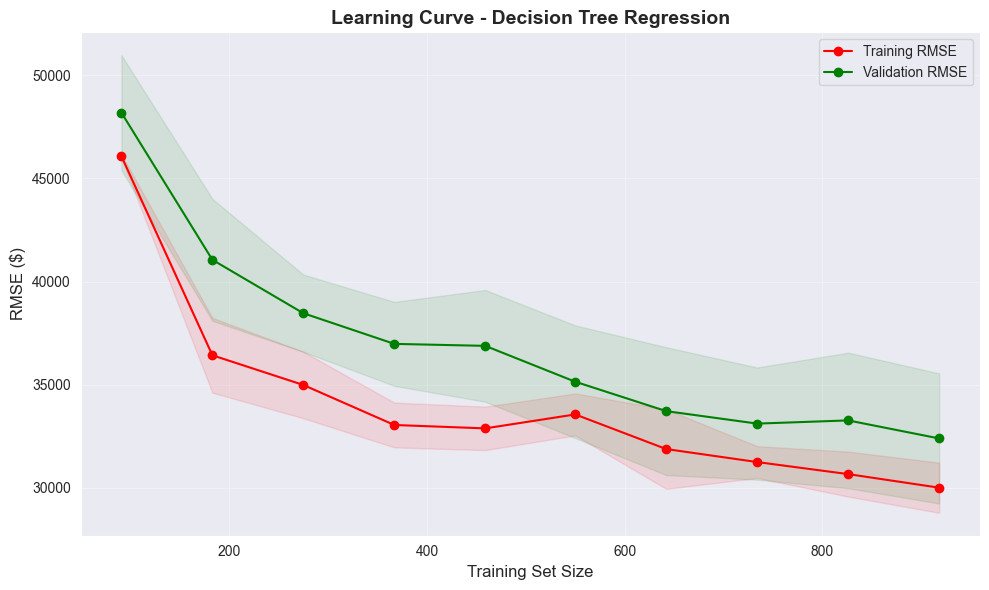


Learning curve generated successfully!


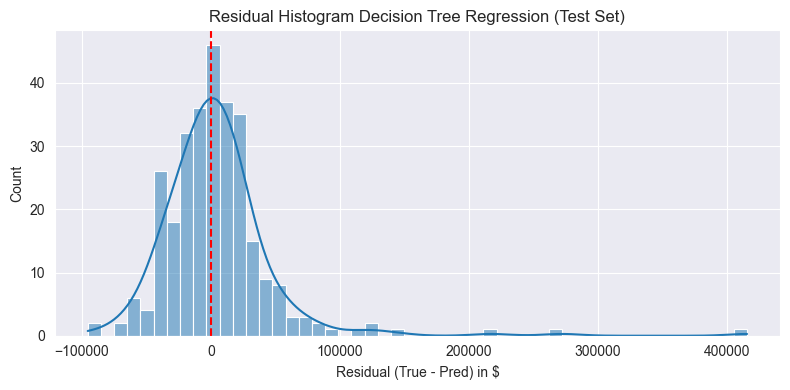

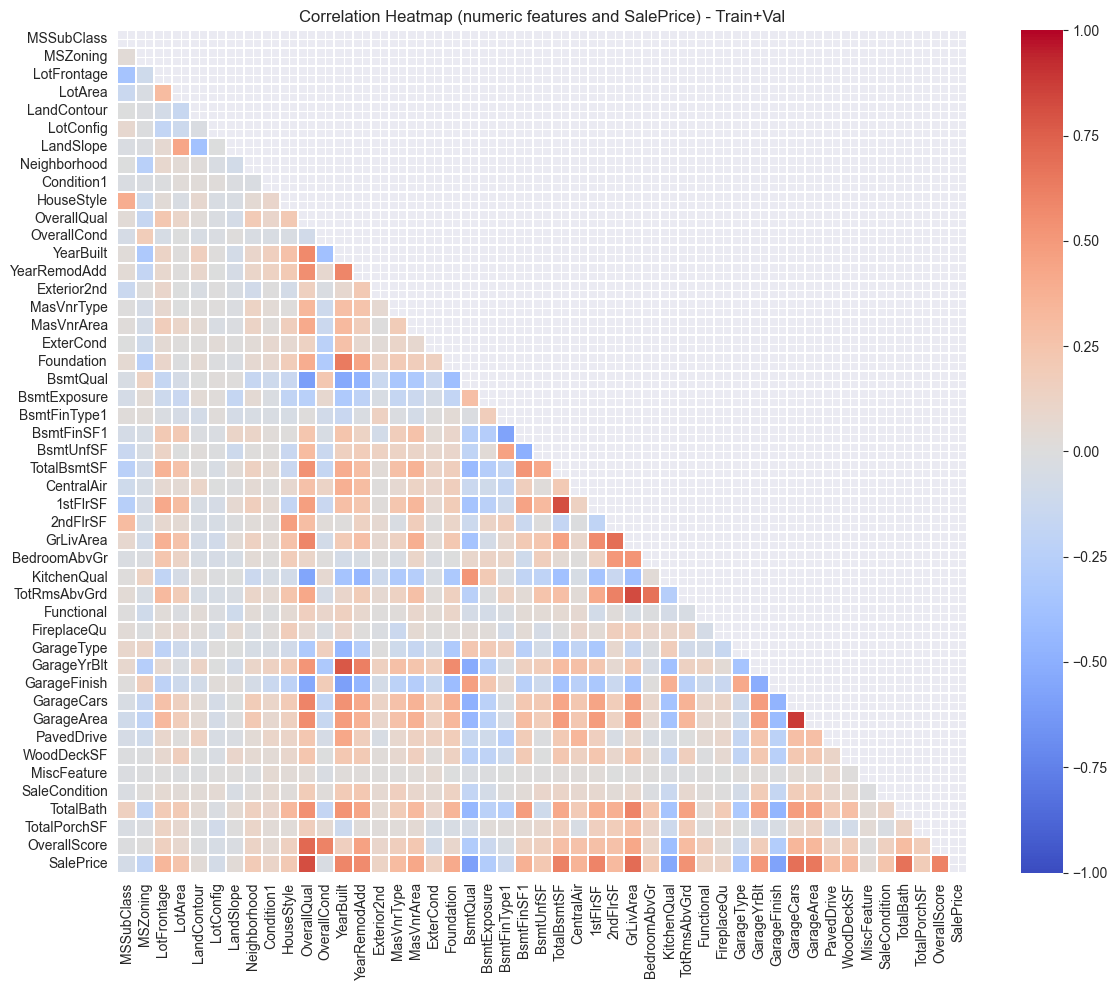

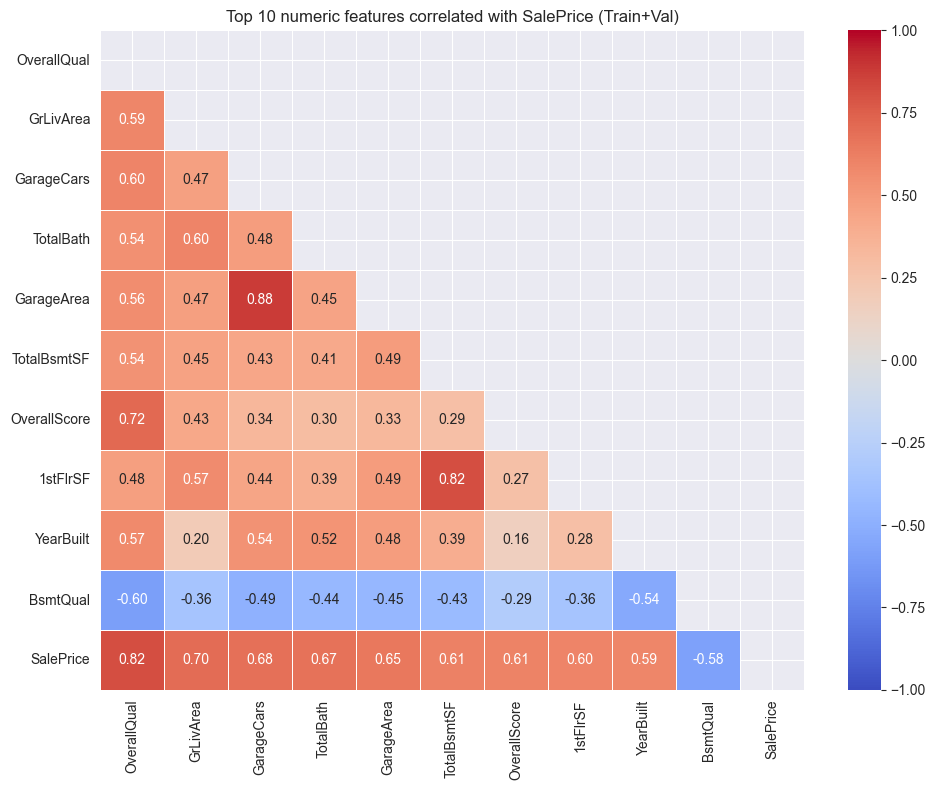

In [94]:
with mlflow.start_run(run_name="Decision Tree Regressor"):
    mlflow.log_param("model_type", "DecisionTreeRegressor")
    mlflow.log_param("cv_folds", 5)
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)
    mlflow.log_params({f"best_{k}": v for k, v in grid_search_dt.best_params_.items()})
    mlflow.log_metric("cv_rmse", best_cv_dt)
    mlflow.log_metric("train_rmse", train_rmse_dt)
    mlflow.log_metric("train_mae", train_mae_dt)

# Step 8: Decision Tree Regression Learning Curve with RMSE
print("\nGenerating learning curve...")
from sklearn.model_selection import learning_curve

# Calculate learning curve
train_sizes, train_scores, val_scores = learning_curve(
    best_model_dt,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    random_state=42
)


train_rmse_scores = np.sqrt(-train_scores)
val_rmse_scores = np.sqrt(-val_scores)

mean_log_y = np.mean(y_train)
train_rmse_dollars = np.exp(mean_log_y) * train_rmse_scores
val_rmse_dollars = np.exp(mean_log_y) * val_rmse_scores

train_rmse_mean = np.mean(train_rmse_dollars, axis=1)
train_rmse_std = np.std(train_rmse_dollars, axis=1)
val_rmse_mean = np.mean(val_rmse_dollars, axis=1)
val_rmse_std = np.std(val_rmse_dollars, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmse_mean, 'o-', color='r', label='Training RMSE')
plt.fill_between(train_sizes,
                 train_rmse_mean - train_rmse_std,
                 train_rmse_mean + train_rmse_std,
                 alpha=0.1, color='r')

plt.plot(train_sizes, val_rmse_mean, 'o-', color='g', label='Validation RMSE')
plt.fill_between(train_sizes,
                 val_rmse_mean - val_rmse_std,
                 val_rmse_mean + val_rmse_std,
                 alpha=0.1, color='g')

plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('RMSE ($)', fontsize=12)
plt.title('Learning Curve - Decision Tree Regression', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
mlflow.log_figure(plt.gcf(), 'dt_learning_curve.png')
plt.show()

print("\nLearning curve generated successfully!")

#Decision Tree Visualizations

# Residual histogram
y_test_actual = np.expm1(y_test)
y_test_pred_dt_actual = np.expm1(y_test_pred_dt_log)
residuals = y_test_actual - y_test_pred_dt_actual

plt.figure(figsize=(8,4))
sns.histplot(residuals, bins=50, kde=True, color='C0')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residual (True - Pred) in $')
plt.title('Residual Histogram Decision Tree Regression (Test Set)')
plt.tight_layout()
mlflow.log_figure(plt.gcf(), 'dt_residual_histogram.png')
plt.show()


numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Correlation heatmap for numeric features (train+val)
df_corr = pd.concat([X[numeric_cols].reset_index(drop=True), y.reset_index(drop=True)], axis=1)
corr = df_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12,10))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, vmin=-1, vmax=1, linewidths=0.1)
plt.title('Correlation Heatmap (numeric features and SalePrice) - Train+Val')
plt.tight_layout()
mlflow.log_figure(plt.gcf(), 'dt_correlation_heatmap.png')
plt.show()

# Select top-10 numeric features most correlated with SalePrice and plot their correlation heatmap
# (uses numeric_cols_filtered, X_cv and y_cv from earlier)

# 1) compute absolute correlations with target and pick top 10
corr_with_target = X[numeric_cols].corrwith(y).abs().sort_values(ascending=False)
top_features = corr_with_target.head(10).index.tolist()

# 2) build dataframe with those top features + SalePrice
df_corr = pd.concat([X[top_features].reset_index(drop=True), y.reset_index(drop=True)], axis=1)

# 3) correlation matrix and heatmap (masked upper triangle), annotated
corr = df_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    mask=mask,
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    annot=True,
    fmt=".2f",
    square=False
)
plt.title('Top 10 numeric features correlated with SalePrice (Train+Val)')
plt.tight_layout()
mlflow.log_figure(plt.gcf(), 'dt_correlation_heatmap_10.png')
plt.show()
mlflow.end_run()

In [95]:
# Summary

print("\n" + "="*60)
print(f"Dataset: Housing Prices with {X.shape[1]} features")
print("="*60)
print("SUMMARY - RIDGE REGRESSION MODEL")
print("="*60)
print(f"Model: Ridge")
print(f"Train/Test Split: 80/20 (random_state=42)")
print(f"Cross-validation: 5-fold")
print(f"\nBest Hyperparameters:")
for param, value in grid_search_lr.best_params_.items():
    print(f"  - {param}: {value}")
print(f"\nPerformance Metrics:")
print(f"  CV RMSE: ${best_cv_lr:,.2f}")
print(f"  Training RMSE: ${train_rmse_lr:,.2f}")
print(f"  Training MAE: ${train_mae_lr:,.2f}")
print(f"  Training R²: {train_r2_lr:.4f}")
print(f"  Test RMSE: ${test_rmse_lr:,.2f}")
print(f"  Test MAE: ${test_mae_lr:,.2f}")
print(f"  Test R²: {test_r2_lr:.4f}")
print("="*60)

print("\n" + "="*60)
print("SUMMARY - DECISION TREE REGRESSION MODEL")
print("="*60)
print(f"Model: Decision Tree Regressor")
print(f"Train/Test Split: 80/20 (random_state=42)")
print(f"Cross-validation: 5-fold")
print(f"\nBest Hyperparameters:")
for param, value in grid_search_dt.best_params_.items():
    print(f"  - {param}: {value}")
print(f"\nPerformance Metrics:")
print(f"  CV RMSE: ${best_cv_dt:,.2f}")
print(f"  Training RMSE: ${train_rmse_dt:,.2f}")
print(f"  Training MAE: ${train_mae_dt:,.2f}")
print(f"  Training R²: {train_r2_dt:.4f}")
print(f"  Test RMSE: ${test_rmse_dt:,.2f}")
print(f"  Test MAE: ${test_mae_dt:,.2f}")
print(f"  Test R²: {test_r2_dt:.4f}")
print("="*60)


Dataset: Housing Prices with 46 features
SUMMARY - RIDGE REGRESSION MODEL
Model: Ridge
Train/Test Split: 80/20 (random_state=42)
Cross-validation: 5-fold

Best Hyperparameters:
  - alpha: 10
  - max_iter: 1000
  - tol: 0.0001

Performance Metrics:
  CV RMSE: $0.15
  Training RMSE: $32,148.43
  Training MAE: $16,619.20
  Training R²: 0.7832
  Test RMSE: $29,738.53
  Test MAE: $18,705.98
  Test R²: 0.8847

SUMMARY - DECISION TREE REGRESSION MODEL
Model: Decision Tree Regressor
Train/Test Split: 80/20 (random_state=42)
Cross-validation: 5-fold

Best Hyperparameters:
  - ccp_alpha: 0.0
  - criterion: squared_error
  - max_depth: 5
  - max_features: log2
  - min_samples_leaf: 30
  - min_samples_split: 50

Performance Metrics:
  CV RMSE: $0.19
  Training RMSE: $31,930.55
  Training MAE: $22,878.43
  Training R²: 0.7861
  Test RMSE: $45,750.17
  Test MAE: $27,183.25
  Test R²: 0.7271
